# Setup

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
TRAIN_VIDEOS_PATH = "/mnt/dat/thes/Train"
TEST_VIDEOS_PATH = "/mnt/dat/thes/Test"

In [3]:
train_df = pd.read_csv("data/SnapUGC/train_out.txt", sep='\t')
train_df['Set'] = 'train'

test_df = pd.read_csv("data/SnapUGC/test_out.txt", sep='\t')
test_df['Set'] = 'test'

df = pd.concat([train_df, test_df])

display(df)
len(train_df), len(test_df), len(df)

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train
4,20c0ea87f1d3d7ce1f5480a8d748e48e,9.976633,0,0,NaN,NaN,https://bolt-gcdn.sc-cdn.net/y/OWVh8dymJFW6fVo...,train
...,...,...,...,...,...,...,...,...
15635,4c358a2ab313460ae13f91f5bd559d96,6.773433,44551,131081,Name a better penalty takereyes womensworldcu...,I should be taking penalties at the women’s Wo...,https://bolt-gcdn.sc-cdn.net/y/T5n7jvYxN8sitP0...,test
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test
15638,5f3908c3e4298ea00a6e3f33bea23a46,14.933333,2139,131097,gothgirl plussize thickwomen chubby curvy...,NaN,https://cf-st.sc-cdn.net/d/DeVWxuTXeZ42TVwHmDf...,test


(113810, 15640, 129450)

# Only select video with duration 10-60s

In [4]:
df = df[(df['Video_len'] >= 10) & (df['Video_len'] <= 60)]
df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train
6,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train
...,...,...,...,...,...,...,...,...
15633,62c9e70d1a124570a7633ae2956621c3,23.300000,1815,131039,Thats Hot. Bbw bbwcontent bbwgoddess bbwqu...,NaN,https://cf-st.sc-cdn.net/d/VYqFXqDsbDfb8BwSL3o...,test
15634,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test


# Normalize order to 0-1

In [5]:
mmscl = MinMaxScaler()

df['ECR'] = mmscl.fit_transform(df['order of ECR'].to_numpy()[:, np.newaxis])[:, 0]
df['NAWP'] = mmscl.fit_transform(df['order of NAWP'].to_numpy()[:, np.newaxis])[:, 0]
df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train,0.000000,0.000000
6,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
15633,62c9e70d1a124570a7633ae2956621c3,23.300000,1815,131039,Thats Hot. Bbw bbwcontent bbwgoddess bbwqu...,NaN,https://cf-st.sc-cdn.net/d/VYqFXqDsbDfb8BwSL3o...,test,0.014205,0.999535
15634,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test,0.371187,0.999596
15636,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test,0.275392,0.999893
15637,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,https://cf-st.sc-cdn.net/c/0fhMhCjPIhZsccU7fmS...,test,0.012459,0.999924


# Select filtered videos

In [6]:
train_videos = glob.glob(os.path.join(TRAIN_VIDEOS_PATH, "*.mp4"))
test_videos = glob.glob(os.path.join(TEST_VIDEOS_PATH, "*.mp4"))

len(train_videos), len(test_videos)

KeyboardInterrupt: 

In [ ]:
train_videos = pd.DataFrame({"Id": [s[s.rfind("/")+1:s.rfind(".mp4")] for s in train_videos],
                             "Video": train_videos,
                             "Set": "train"})
test_videos = pd.DataFrame({"Id": [s[s.rfind("/")+1:s.rfind(".mp4")] for s in test_videos],
                             "Video": test_videos,
                             "Set": "test"})

videos_df = pd.concat([train_videos, test_videos])
videos_df

,Id,Video,Set
0,e0d0c5003ace0db8441f126acca23763,/mnt/dat/thes/Train/e0d0c5003ace0db8441f126acc...,train
1,d5cf30e9cde207914c63ee418c44f9da,/mnt/dat/thes/Train/d5cf30e9cde207914c63ee418c...,train
2,59758d35d60f814d28fa96d838f26ff8,/mnt/dat/thes/Train/59758d35d60f814d28fa96d838...,train
3,8de7a01eb31b520e27fd100afb4ed26c,/mnt/dat/thes/Train/8de7a01eb31b520e27fd100afb...,train
4,b846bfc3a8c5520f29b5d0d6b1f09028,/mnt/dat/thes/Train/b846bfc3a8c5520f29b5d0d6b1...,train
...,...,...,...
14780,4ffba70ee271fb47b869aa021d623dfe,/mnt/dat/thes/Test/4ffba70ee271fb47b869aa021d6...,test
14781,eed0c278570db4ea8da9fbe4cd20c10f,/mnt/dat/thes/Test/eed0c278570db4ea8da9fbe4cd2...,test
14782,79856890456080f9083f5dad4710ad8a,/mnt/dat/thes/Test/79856890456080f9083f5dad471...,test
14783,8d58592ccb48b1488e67f78df7fa71a2,/mnt/dat/thes/Test/8d58592ccb48b1488e67f78df7f...,test


In [ ]:
df = pd.merge(df, videos_df, how='inner', on=['Id', 'Set'])
df.set_index('Id', drop=True, inplace=True)
df

,Video_len,order of ECR,order of NAWP,Title,Description,Link,Set,ECR,NAWP,Video
Id,,,,,,,,,,
5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,https://cf-st.sc-cdn.net/d/Pi2xtXMNjx6GfVEJnmo...,train,0.000000,0.000000,/mnt/dat/thes/Train/5902367b4d7d4c38fe4638593d...
9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,https://cf-st.sc-cdn.net/d/p8788TQnO5KF94SH8Uz...,train,0.000000,0.000000,/mnt/dat/thes/Train/9be2d4d5e8d4bfd1f5ce59f51d...
1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,https://cf-st.sc-cdn.net/d/0EnBGUijvMSYNKc6yMP...,train,0.000000,0.000000,/mnt/dat/thes/Train/1d5a6586d42b5b0d69f48a7ba8...
1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,https://cf-st.sc-cdn.net/d/7xbgKKhZWSVFpOnIAmN...,train,0.000000,0.000000,/mnt/dat/thes/Train/1e9b26ba367a8ed55991659929...
e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,https://cf-st.sc-cdn.net/d/szw4nAI2himrr6T5snK...,train,0.000000,0.000000,/mnt/dat/thes/Train/e86dbca9869239fcf2d04373f9...
...,...,...,...,...,...,...,...,...,...,...
58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,https://cf-st.sc-cdn.net/d/YqSwFUx26BXDuj0ZORl...,test,0.269961,0.999466,/mnt/dat/thes/Test/58ec27987a35909f4006f136118...
26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,https://cf-st.sc-cdn.net/d/pWjLpUnbas8co3ANSyO...,test,0.371187,0.999596,/mnt/dat/thes/Test/26e446b86f92faa89d88a58d03e...
72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,https://cf-st.sc-cdn.net/d/QzHW2ArktQL19EPZAqg...,test,0.275392,0.999893,/mnt/dat/thes/Test/72ae9bac4dd52c9e6befc90d9ba...


# Data exploration

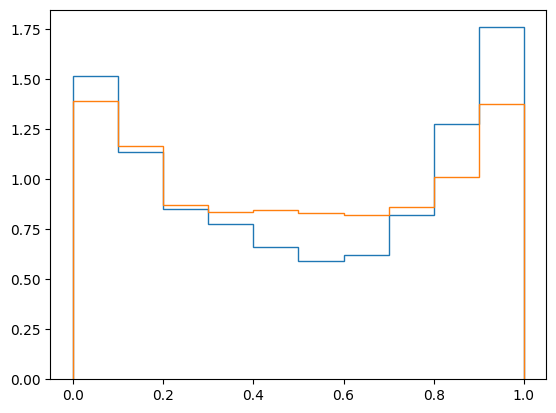

In [ ]:
plt.hist(df['NAWP'], density=True, histtype='step')
plt.hist(df['ECR'], density=True, histtype='step')
plt.show()

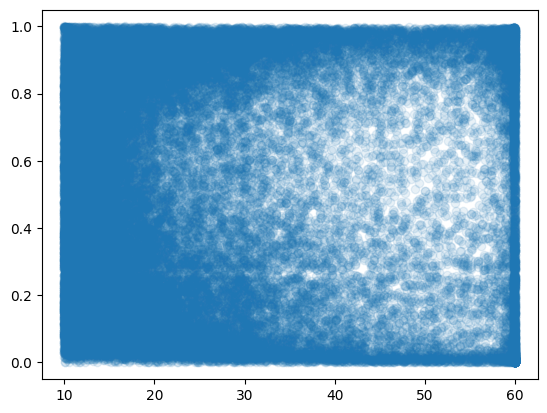

In [ ]:
plt.scatter(df['Video_len'], df['NAWP'], alpha=0.1)
plt.show()

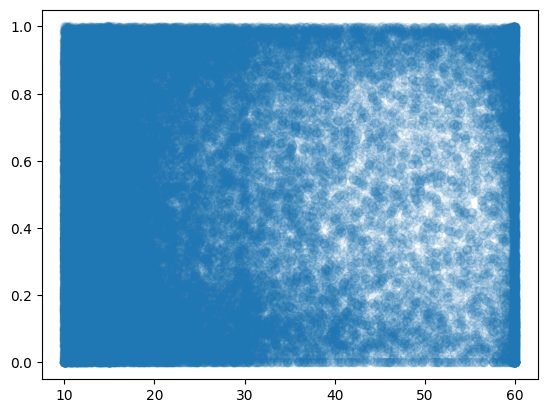

In [ ]:
plt.scatter(df['Video_len'], df['ECR'], alpha=0.1)
plt.show()

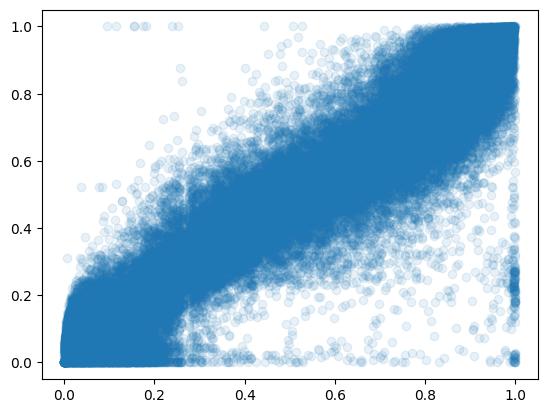

In [ ]:
plt.scatter(df['NAWP'], df['ECR'], alpha=0.1)
plt.show()

# Convert video to tensors

In [ ]:
VIDEO_FPS = 4
AUDIO_FPS = 8196

In [ ]:
sample = df.sample(n=1).iloc[0]
sample

Video_len                                                18.833333
order of ECR                                                  4297
order of NAWP                                                 8495
Title            Nothing worse than getting caughtface with tea...
Description                      Nothing worse than getting caught
Link             https://cf-st.sc-cdn.net/d/JRyIPki7bKTHgVX2wnZ...
Set                                                          train
ECR                                                        0.03363
NAWP                                                      0.064798
Video            /mnt/dat/thes/Train/aa2e4c31e011bfcc8dbfd585b5...
Name: aa2e4c31e011bfcc8dbfd585b572323f, dtype: object

In [ ]:
from moviepy import VideoFileClip
import numpy as np


def video_to_tensor(path, video_fps, audio_fps):
    # Load the video file
    video_clip = VideoFileClip(path)

    # Extract frames    
    frames = np.array(list(video_clip.iter_frames(fps=video_fps, dtype="uint8"))) # Shape: (num_frames, height, width, 3)

    # Extract audio as numpy array
    audio = video_clip.audio
    if audio is not None:
        audio_samples = np.array(list(audio.iter_frames(fps=audio_fps)))
    else:
        audio_samples = None

    # Close video to free resources
    video_clip.close()
    
    return frames, audio_samples


frames, audio_samples = video_to_tensor(sample['Video'], VIDEO_FPS, AUDIO_FPS)
# Print shapes
print("Frames shape:", frames.shape)  # e.g., (num_frames, height, width, 3)
if audio_samples is not None:
    print("Audio shape:", audio_samples.shape)  # e.g., (num_audio_samples, num_channels)

Frames shape: (75, 854, 480, 3)
Audio shape: (154330, 2)


In [ ]:
# plt.imshow(frames[7])

# import sounddevice as sd
# remember to install libportaudio2
# audio_samples = audio_samples / np.max(np.abs(audio_samples))
# print("Playing audio...")
# sd.play(audio_samples, samplerate=AUDIO_FPS, blocksize=1024)
# sd.wait()

# Prepare dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


class CustomVideoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, id):
        try:
            row = self.df.loc[id]
        except KeyError:
            return None        
        
        video_path = row['Video']
        ecr = row['ECR']
        nawp = row['NAWP']
        
        if self.transform:
            video = self.transform(video_path)
        if self.target_transform:
            label = self.target_transform(ecr, nawp)
        return video, label
    
train_set = CustomVideoDataset(df[df['Set'] == 'train'], transform=video_to_tensor)
test_set = CustomVideoDataset(df[df['Set'] == 'test'], transform=video_to_tensor)

len(train_set), len(test_set)

(50904, 6934)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)